<a href="https://colab.research.google.com/github/preetham3216/info5731-fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install gensim==3.8.3

In [ ]:
# Write your code here
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

df = pd.read_csv('userReviews.csv')
print(df.columns)

df.columns = df.columns.str.replace(' ','_')
df.head()

Index(['Unnamed: 0', 'User Reviews'], dtype='object')


,Unnamed:_0,User_Reviews
0,0,Disney/Marvel has been applauded for its ethni...
1,1,Shaun (Simu Liu) and Katy (Awkwafina) are park...
2,2,"I was not expecting that, I had visions of a f..."
3,3,The Marvel Cinematic Universe made a big impac...
4,4,I find this film very engaging from start to f...


In [ ]:

data = df.User_Reviews.values.tolist()
print(len(data))
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1]) 


13
['Disney/Marvel has been applauded for its ethnic diversity in their superhero '
 'movies.There is a danger that it could evolve into a cookie cutter approach. '
 'Take the easy way out and follow the Black Panther formula.Shang-Chi and the '
 'Legend of the Ten Rings does ride that wave.Shaun/Shang-Chi (Simu Liu) is a '
 'slacker in San Francisco parking cars along with best friend Katy '
 '(Awkwafina.) Both live an easy lifestyle that involves hard partying. Their '
 'other friends have settled down and gone for career goals.For Shaun '
 'everything changes when he is attacked one day on the bus. Katy discovers '
 'that Shaun has some whip smart martial arts moves.Shaun believes that his '
 'father Wenwu a notorious gangster has sent the goons. His sister might also '
 'be in danger and flies off to find her.Indeed Wenwu is an infamous and long '
 'lived immortal thanks to the Ten Rings. He changed his bad ways when he met '
 'and married a woman from a mystical land called Tal-Lo

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"go" + 0.027*"love" + 0.014*"act" + 0.014*"line" + 0.014*"pace" + '
  '0.014*"expect" + 0.014*"way" + 0.014*"second" + 0.014*"watch" + '
  '0.014*"masterpiece"'),
 (1,
  '0.021*"shaun" + 0.016*"movie" + 0.016*"marvel" + 0.016*"black" + '
  '0.011*"good" + 0.011*"martial_art" + 0.011*"feel" + 0.011*"go" + '
  '0.011*"friend" + 0.011*"panther"'),
 (2,
  '0.002*"movie" + 0.001*"year" + 0.001*"ve" + 0.001*"character" + '
  '0.001*"find" + 0.001*"show" + 0.001*"ring" + 0.001*"love" + 0.001*"do" + '
  '0.001*"well"'),
 (3,
  '0.001*"shang_chi" + 0.001*"ring" + 0.001*"movie" + 0.001*"wenwu" + '
  '0.001*"year" + 0.001*"character" + 0.001*"ve" + 0.001*"find" + '
  '0.001*"world" + 0.001*"help"'),
 (4,
  '0.001*"movie" + 0.001*"shang_chi" + 0.001*"show" + 0.001*"well" + '
  '0.001*"think" + 0.001*"panther" + 0.001*"get" + 0.001*"actor" + '
  '0.001*"black" + 0.001*"do"'),
 (5,
  '0.002*"ring" + 0.002*"shang_chi" + 0.002*"wenwu" + 0.002*"year" + '
  '0.001*"go" + 0.001*"dweller" + 

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.181165029103639

Coherence Score:  0.40726970932181883


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.007792  0.211447       1        1  28.117042
15     0.093658 -0.032662       2        1  19.979741
9     -0.151601  0.029867       3        1  12.367602
13     0.098824 -0.166930       4        1  12.091133
16    -0.235383 -0.081136       5        1  10.974664
1      0.093736  0.105182       6        1  10.249435
0      0.043656 -0.037125       7        1   2.543988
14     0.031105 -0.046935       8        1   2.216289
11     0.026377 -0.006117       9        1   1.233096
8     -0.000535  0.000652      10        1   0.022440
10     0.001226  0.003476      11        1   0.021750
3      0.000931  0.001576      12        1   0.021696
2      0.000187  0.001009      13        1   0.020995
18    -0.000149  0.004033      14        1   0.020210
5     -0.000471  0.003370      15        1   0.020208
4      0.002088  0.001824      16        1   0.020167
17     0.000787  0.002478      17        1   0.020135
6      0.000356  0.001654      18        1   0.020125
19     0.001716  0.001322      19        1   0.020041
12     0.001283  0.003016      20        1   0.019242, topic_info=          Term       Freq      Total Category  logprob  loglift
80        ring  22.000000  22.000000  Default  30.0000  30.0000
350  shang_chi  16.000000  16.000000  Default  29.0000  29.0000
104      wenwu  12.000000  12.000000  Default  28.0000  28.0000
223    dweller   6.000000   6.000000  Default  27.0000  27.0000
16   character  13.000000  13.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
327    pendant   0.000403   4.857215  Topic20  -6.5914  -0.8421
195     battle   0.000402   3.934877  Topic20  -6.5923  -0.6324
203    chinese   0.000402   3.976818  Topic20  -6.5926  -0.6434
285       kill   0.000402   3.852908  Topic20  -6.5934  -0.6125
144       year   0.000402  13.870526  Topic20  -6.5940  -1.8940

[1362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
699       4  1.010498  absolutely
145       2  0.501297         act
145       3  0.167099         act
145       4  0.167099         act
145       6  0.167099         act
...     ...       ...         ...
144       1  0.216286        year
144       2  0.072095        year
144       3  0.288381        year
144       4  0.144191        year
144       5  0.360477        year

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 10, 14, 17, 2, 1, 15, 12, 9, 11, 4, 3, 19, 6, 5, 18, 7, 20, 13])

In [ ]:
mallet_path = "mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

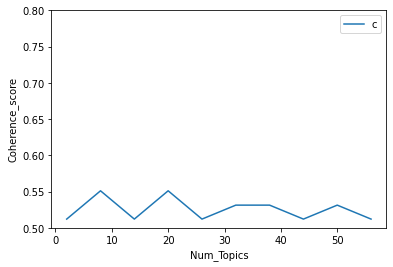

In [ ]:
import matplotlib.pyplot as plots
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plots.plot(x, coherence_values)
plots.xlabel("Num_Topics")
plots.ylabel("Coherence_score")
plots.legend(("coherence_values"), loc='best')
plots.ylim([0.5, 0.8])
plots.show()

## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
datfram =pd.read_csv(r'userReviews.csv',index_col=0)
datfram

,User Reviews
0,Disney/Marvel has been applauded for its ethni...
1,Shaun (Simu Liu) and Katy (Awkwafina) are park...
2,"I was not expecting that, I had visions of a f..."
3,The Marvel Cinematic Universe made a big impac...
4,I find this film very engaging from start to f...
5,Shang-Chi leaves San Francisco with his friend...
6,I've said this before about Marvel movies: the...
7,Serviceable. That's the word that came to my m...
8,Shang Chi was nowhere near the top of my most ...
9,With no real concept of the character or the s...


In [ ]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles
docs_list,titles=load_data(r'','userReviews.csv')

Total Number of Documents: 14


In [ ]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        i=str(i)
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
texts=preprocess_data(docs_list)

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix=prepare_corpus(texts)

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel
lsa_model=create_gensim_lsa_model(texts,5,100)

[(0, '0.369*"wenwu" + 0.368*"shang" + 0.368*"chi" + 0.294*"ring" + 0.239*"ten" + 0.160*"kati" + 0.150*"xial" + 0.116*"lo" + 0.114*"villag" + 0.114*"li" + 0.112*"dweller" + 0.112*"ta" + 0.110*"year" + 0.096*"dark" + 0.095*"fight" + 0.084*"attack" + 0.080*"gate" + 0.079*"movi" + 0.073*"go" + 0.071*"world" + 0.071*"past" + 0.070*"pendant" + 0.068*"great" + 0.066*"gang" + 0.066*"iron" + 0.064*"escap" + 0.063*"save" + 0.063*"liu" + 0.062*"use" + 0.060*"train" + 0.056*"power" + 0.055*"help" + 0.054*"dragon" + 0.054*"battl" + 0.052*"father" + 0.052*"love" + 0.051*"wong" + 0.050*"awkwafina" + 0.050*"chines" + 0.050*"charact" + 0.050*"friend" + 0.048*"came" + 0.048*"minion" + 0.048*"arriv" + 0.048*"organis" + 0.048*"high" + 0.048*"hero" + 0.048*"protector" + 0.047*"marvel" + 0.047*"two" + 0.046*"good" + 0.044*"black" + 0.044*"would" + 0.044*"decid" + 0.044*"kill" + 0.044*"destroy" + 0.043*"sister" + 0.041*"also" + 0.041*"old" + 0.041*"best" + 0.040*"mother" + 0.040*"half" + 0.040*"leung" + 0.04

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
model_list,coherence_values=compute_coherence_values(dictionary,doc_term_matrix,texts,12,2,1)

In [ ]:
print(coherence_values)

[0.5121431869755998, 0.5121431869755998, 0.5511816554414725, 0.4923594469136228, 0.5121431869755998, 0.4923594469136228, 0.5313979153794954, 0.5511816554414725, 0.5121431869755998, 0.4923594469136228]


In [ ]:
def plot_graph(doc_clean,start,stop,step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start,stop,step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

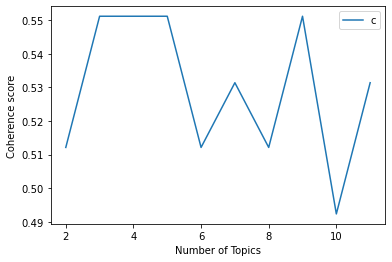

In [ ]:
start,stop,step=2,12,1
plot_graph(texts,start,stop,step)

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

# Write your answer here (no code needed for this question)

LSA is  a technique for detecting themes in a text database.
The central concept is to turn the data into a matrix including words and themes. 
By splitting the words into a separate topic-term matrix and document-term matrix, we can successfully execute Topic modelling based on the matrices.
We acheived a coherance score around .40

LDA is a technique for resolving topic modeling issues.
The central concept is to process the document term matrix and the topic term matrix, as well as to do topic modeling. 
LDA learns from the Unstructured groupings using the training data set. As a result, the majority of the issues are relatively similar.
We acheived coherence score around .51
